In [2]:
from Convolutional_Network import conv_net
import FinanceDataManager
import Preprocessing

import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.layers.convolutional import  Conv1D, MaxPooling1D

In [3]:
data_manager = FinanceDataManager.FinanceDataManager()
data = data_manager.get_prices(stock_name="AAPL", start = "2010-01-01", end = "2019-10-01")
window_size = 20
data

0        26.193771
1        26.601469
2        26.647457
3        26.223597
4        26.175119
           ...    
2448    217.028412
2449    220.368393
2450    219.231812
2451    218.165024
2452    223.299591
Name: Close, Length: 2453, dtype: float64

In [4]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [15]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    
    timeseries.shape
    
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    
    print(X.shape)
    
    
    Y = timeseries[window_size:]
    
    print(Y.shape)
    
    return X, Y

In [6]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.3):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
        
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    
    nb_samples, nb_series = timeseries.shape
    
    
    model = make_1d_convnet(window_size=window_size, filter_length=filter_length,
                            nb_input_series=nb_series,
                            nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)
    
    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
    
    
    #--------
    
    print(X_test.shape)
    
    
    #--------
    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)
    
    preds   = model.predict(X_test)
    

    return Y_test, preds , model

In [11]:
# adatok elkészítése
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))
window_size = 20


#np.ndarray(data)
#type(data.values)
#X.shape
#data.values.shape
len(data)

2705

In [16]:
targets, preds, model = evaluate_timeseries(data.values, window_size)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 8, 4)              0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
________________________________________________________

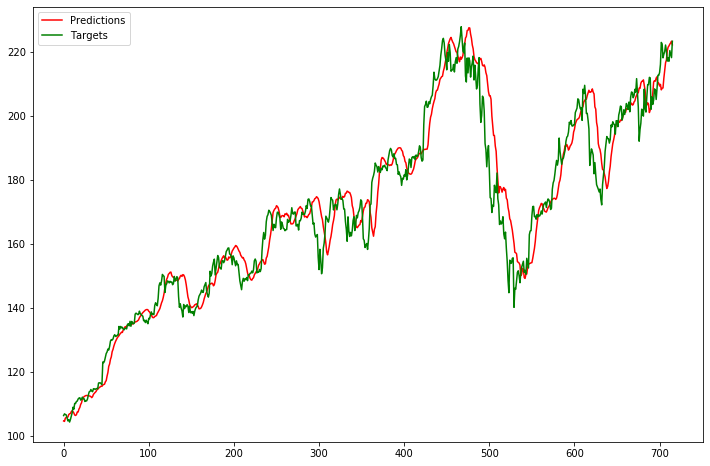

In [21]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()

In [ ]:
np.array(data.tail(10))

In [18]:
model.predict([[100]])

ValueError: Error when checking input: expected conv1d_5_input to have 3 dimensions, but got array with shape (1, 1)